# 2A.ml - Imbalanced dataset

Un jeu de données *imbalanced* signifie qu'une classe est sous représentée dans un problème de classification. Lire [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Génération de données

On génère un problème de classification binaire avec une classe sous représentée.

In [3]:
import numpy.random
import pandas

def generate_data(nb, ratio, noise):
    mat = numpy.random.random((nb,2))
    noise = numpy.random.random((mat.shape[0],1)) * noise
    data = pandas.DataFrame(mat, columns=["X1", "X2"])
    data["decision"] = data.X1 + data.X2 + noise.ravel()
    vec = list(sorted(data["decision"]))
    l = len(vec)- 1 - int(len(vec) * ratio)
    seuil = vec[l]
    data["cl"] = data["decision"].apply(lambda r: 1 if r > seuil else 0)
    from sklearn.utils import shuffle
    data = shuffle(data)
    return data

data = generate_data(1000, 0.02, 0.1)
data.describe()

,X1,X2,decision,cl
count,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.507398,0.504369,1.062076,0.02000
std,0.273177,0.291053,0.406295,0.14007
min,0.001254,0.000229,0.077349,0.00000
25%,0.283953,0.250206,0.775429,0.00000
50%,0.508426,0.499863,1.052453,0.00000
75%,0.724989,0.752632,1.363265,0.00000
max,0.999081,0.999793,2.003768,1.00000


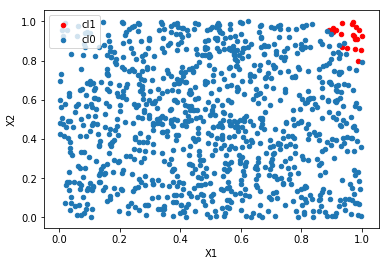

In [4]:
ax = data[data.cl==1].plot(x="X1", y="X2", kind="scatter", label="cl1", color="r")
data[data.cl==0].plot(x="X1", y="X2", kind="scatter", label="cl0", ax=ax)

In [5]:
from sklearn.model_selection import train_test_split
while True:
    X_train, X_test, y_train, y_test = train_test_split(data[["X1", "X2"]], data["cl"])
    if sum(y_test) > 0:
        break

Le découpage apprentissage est délicat car il n'y pas beaucoup d'exemples pour la classe sous-représentée.

In [6]:
y_test.sum()

1

## Apprendre et tester un modèle

In [7]:
from sklearn.metrics import confusion_matrix

def confusion(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predt = model.predict(X_train)
    c_train = confusion_matrix(y_train, predt)
    pred = model.predict(X_test)
    c_test = confusion_matrix(y_test, pred)
    return pandas.DataFrame(numpy.hstack([c_train, c_test]), index=["y=0", "y=1"],
                            columns="train:y=0 train:y=1 test:y=0 test:y=1".split())

from sklearn.linear_model import LogisticRegression
confusion(LogisticRegression(), X_train, X_test, y_train, y_test)

,train:y=0,train:y=1,test:y=0,test:y=1
y=0,731,0,249,0
y=1,19,0,1,0


Quelques exemples pour tester, quelques exemples pour apprendre. C'est peu.

In [8]:
from sklearn.tree import DecisionTreeClassifier
confusion(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

,train:y=0,train:y=1,test:y=0,test:y=1
y=0,731,0,249,0
y=1,0,19,0,1


In [9]:
from sklearn.ensemble import RandomForestClassifier
confusion(RandomForestClassifier(), X_train, X_test, y_train, y_test)

,train:y=0,train:y=1,test:y=0,test:y=1
y=0,731,0,249,0
y=1,0,19,1,0


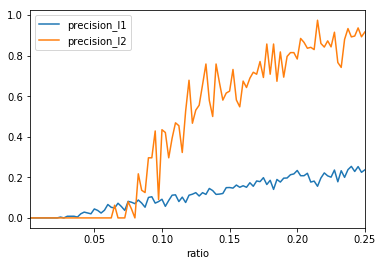

In [10]:
ratio = list(_/400.0 for _ in range(1, 101))
rows = []
for r in ratio:
    data = generate_data(1000, r, noise=0.0)
    while True:
        X_train, X_test, y_train, y_test = train_test_split(data[["X1", "X2"]], data["cl"])
        if sum(y_test) > 0 and sum(y_train) > 0:
            break
    c = confusion(LogisticRegression(penalty='l1'), X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=0","test:y=0"], c.loc["y=1","test:y=1"]
    row = dict(ratio=r, precision_l1=c1 / (c0 + c1) )
    c = confusion(LogisticRegression(penalty='l2'), X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1","test:y=0"], c.loc["y=1","test:y=1"]
    row["precision_l2"] = c1 / (c0 + c1)
    rows.append(row)
df = pandas.DataFrame(rows)
df.plot(x="ratio", y=[_ for _ in df.columns if _ !="ratio"])

La norme **l1** est plus sensible aux petites classes.

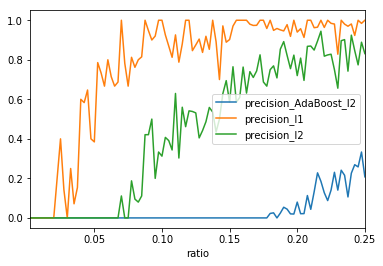

In [11]:
from sklearn.ensemble import AdaBoostClassifier
ratio = list(_/400.0 for _ in range(1, 101))
rows = []
for r in ratio:
    data = generate_data(1000, r, noise=0.0)
    while True:
        X_train, X_test, y_train, y_test = train_test_split(data[["X1", "X2"]], data["cl"])
        if sum(y_test) > 0 and sum(y_train) > 0:
            break
    c = confusion(LogisticRegression(penalty='l1'), X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1","test:y=0"], c.loc["y=1","test:y=1"]
    row = dict(ratio=r, precision_l1=c1 / (c0 + c1) )
    c = confusion(LogisticRegression(penalty='l2'), X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1","test:y=0"], c.loc["y=1","test:y=1"]
    row["precision_l2"] = c1 / (c0 + c1)
    c = confusion(AdaBoostClassifier(LogisticRegression(penalty='l2')), X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1","test:y=0"], c.loc["y=1","test:y=1"]
    row["precision_AdaBoost_l2"] = c1 / (c0 + c1)
    rows.append(row)
df = pandas.DataFrame(rows)
df.plot(x="ratio", y=[_ for _ in df.columns if _ !="ratio"])

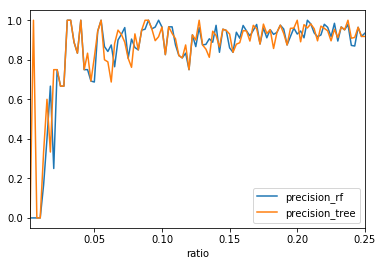

In [12]:
from sklearn.ensemble import AdaBoostClassifier
ratio = list(_/400.0 for _ in range(1, 101))
rows = []
for r in ratio:
    data = generate_data(1000, r, noise=0.0)
    while True:
        X_train, X_test, y_train, y_test = train_test_split(data[["X1", "X2"]], data["cl"])
        if sum(y_test) > 0 and sum(y_train) > 0:
            break
    c = confusion(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1","test:y=0"], c.loc["y=1","test:y=1"]
    row = dict(ratio=r, precision_tree=c1 / (c0 + c1) )
    c = confusion(RandomForestClassifier(), X_train, X_test, y_train, y_test)
    c0, c1 = c.loc["y=1","test:y=0"], c.loc["y=1","test:y=1"]
    row["precision_rf"] = c1 / (c0 + c1)
    rows.append(row)
df = pandas.DataFrame(rows)
df.plot(x="ratio", y=[_ for _ in df.columns if _ != "ratio"])

## Exercice 1 : réduire les exemples loin des frontières

Pour rééquilibrer la proportion des classes, on cherche à enlever des points de la base d'apprentissage pour lesquels il n'y a pas d'ambiguïté, c'est-à-dire loin des frontières. Imaginer une solution à l'aides des [k plus proches voisins](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

## Exercice 2 : multiplier les exemples

L'idée est d'utiliser une technique pour multiplier les exemples de la classe sous-représentée sans pour autant avoir des exemples exactement identiques. On utilise l'algorithme [SMOTE](http://jair.org/media/953/live-953-2037-jair.pdf). En résumé, l'algorithme consiste à créer des exemples pour la classe sous-représentée. On choisit un de ces exemples $X$. Pour cet $X$, on calcule ses $k$ plus proches voisins dans la base d'apprentissage, toutes classes comprises. On choisit un voisin aléatoire $V$ parmi les $k$ voisins. On tire un nombre aléaloire $h\in]0,1]$. Le nouvel élément ajouté à la base d'apprentissage est $X + h (V-X)$ et il est associé à la classe sous-représentée. On continue jusqu'à la proportion souhaitée.

* [SMOTE: Synthetic Minority Over-sampling Technique](http://jair.org/media/953/live-953-2037-jair.pdf)
* [Detecting Click Fraud in Online Advertising: A Data Mining Approach](http://www.jmlr.org/papers/volume15/oentaryo14a/oentaryo14a.pdf)
* [On the Statistical Consistency of Algorithms for Binary Classification under Class Imbalance](http://jmlr.org/proceedings/papers/v28/menon13a.pdf)
* [On multi-class classification through the minimization of the confusion matrix norm](http://jmlr.org/proceedings/papers/v29/Koco13.pdf)

## Exercice 3 : essai du module imbalanced

Ce module implémente différentes façons de gérer les classes sous et sur représentés.

* [algorithmes implémentés](https://github.com/scikit-learn-contrib/imbalanced-learn#about)
* [exemples - imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/index.html)

## Exercice 4 : validation croisée

Lorsqu'une classe est sous représentée, la validation croisée doit être effectuée sous contrainte. Si elle est réalisée de façon complètement aléatoire, il est probable que la classe sous représentée ne soit pas présente. Si la classe 0 possède $k$ exemples parmi $N$, quelle est la distribution du minimum d'observations dans une des clasees ? Il veut comparer une crossvalidation classique avec un échantillon stratigiée ([StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)).